# Image classifier utilities

<a id='top'></a>
#### [Caractéristiques du modèle](#model)

#### [Dataset](#dataset)  
- [Ecriture TFRecords](#write_TFR)
- [Lecture et décodage TFRecords](#read_TFR_base_model)  

#### [Transfer learning: Feature extraction](#top_model)  
- [Evaluation](#eval_feat_extract)  
- [Visualisations](#visu_base)  

#### [Transfer learning: Fine-tuning](#fine_tuning)  
- [Evaluation](#eval_ft)  

#### [Modèle pour inférence](#model_infer)  

#### [Visualisation](#visu)  

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormap
import seaborn as sns

import pandas as pd
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 500
import itertools

import glob
from tqdm.notebook import tqdm
#.notebook.tqdm as tqdm
import re
import random

import pickle
from zipfile import ZipFile
import os
from PIL import Image
import shutil

from IPython.display import Image, display
import datetime

#pd.options.plotting.backend = "plotly"
plt.rcParams['figure.figsize'] = [10, 5]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### VGG16 model caracteristics<a id='model'></a>

[top](#top)

In [19]:
IMAGE_DIM = 224
image_size = (IMAGE_DIM, IMAGE_DIM)
batch_size = 32

In [20]:
# base_model : img --> block5pool
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights="imagenet",
                                         input_tensor=None,
                                         input_shape=(IMAGE_DIM, IMAGE_DIM, 3),
                                         pooling=None,
                                         classes=1000,
                                         classifier_activation="softmax")
base_model.trainable = False

In [21]:
def get_base_model_features(img):
    '''
    Extract pool block4_pool and block5_pool tensors
    '''
    img = keras.preprocessing.image.load_img(img, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    extractor = keras.Model(inputs=base_model.inputs,
                            outputs=[base_model.get_layer('block4_pool').output, 
                                     base_model.get_layer('block5_pool').output])
    features = extractor(img_array)
    features = [f[0] for f in features]
    
    block4_pool_tensor = features[0].numpy()
    block5_pool_tensor = features[1].numpy()

    return block4_pool_tensor, block5_pool_tensor

img = glob.glob('./*.jpg')[0]
get_base_model_features(img)[0].shape, get_base_model_features(img)[1].shape

((14, 14, 512), (7, 7, 512))

### Write TFRecords from directory of images<a id='write_TFR'></a>

[top](#top)

Classes from directory names

In [5]:
# repertoires d'images
DATA_JPG = '../../Data/datasets/data_img_V3/' # fichiers jpg d'origine
DATA_JPG_categories = [x.split('/')[-1] for x in glob.glob(DATA_JPG + '/*')]

category2label = {}
for label, directory in enumerate(sorted(DATA_JPG_categories)):
    category2label[directory] = label

label2category = {v:k for (k,v) in category2label.items()}

CATEGORY_IMAGE_DIRS = sorted([DATA_JPG + x for x in DATA_JPG_categories])

In [7]:
NUM_CLASSES = len(np.unique(list(category2label.values())))
NUM_CLASSES

38

Randomize filenames

In [8]:
def get_randomized_file_list(path_str):
    '''
    renvoie une liste de fichiers jpeg randomisée
    '''
    path = path_str + '/*.jpg'
    lst_img = glob.glob(path)
    random.shuffle(lst_img)
    return lst_img

lst_jpg = []
for category in CATEGORY_IMAGE_DIRS:
    lst_jpg_directory = get_randomized_file_list(category)
    lst_jpg += lst_jpg_directory
    
random.seed(2)
random.shuffle(lst_jpg)

In [10]:
len(lst_jpg)

39440

In [11]:
# labels
file2label = {}

for filename in (lst_jpg):
    category = filename.split('/')[-2]
    file2label[filename] = category2label[category]

Split dataset, pickle list of filenames

In [13]:
lst_img_tr = lst_jpg[:int(0.9*len(lst_jpg))]
lst_img_val = lst_jpg[int(0.9*len(lst_jpg)):]

In [15]:
with open('./lst_img_tr_V3.pkl', 'rb') as f:
    lst_img_tr = pickle.load(f)
with open('./lst_img_val_V3.pkl', 'rb') as f:
    lst_img_val = pickle.load(f)

Write tensor datasets, tr + val split

In [16]:
DATA_TENSORS = '/.../data_img_V3_tensors/'

In [17]:
try:
    os.mkdir(DATA_TENSORS)
except Exception as e:
    print(e)

val dataset :  each shard contains features extracted from `block4_pool` and `block5_pool` and then serialized (reshaped to lists)

In [ ]:
index = 0
n_images_shard = 400 # 400 images per shard
n_shards = int(len(lst_img_val) / n_images_shard) + (1 if len(lst_img_val) % n_images_shard != 0 else 0)

#https://medium.com/@rodrigobrechard/tfrecords-how-to-use-sharding-94059e2b2c6b
for shard in tqdm(range(n_shards)):
    tfrecords_shard_path = "{}_{}.tfrecord".format(DATA_TENSORS 
                                                   + 'img_data_val_', '%.5d-of-%.5d' % (shard, n_shards - 1))
    end = index + n_images_shard if len(lst_img_val) > (index + n_images_shard) else -1
    images_shard_list = lst_img_val[index: end]

    #https://stackoverflow.com/a/45428167
    with tf.io.TFRecordWriter(tfrecords_shard_path) as writer:

        for img in (images_shard_list):
            try:
                base_model_features = get_base_model_features(img)
                lbl = file2label[img]
                example = tf.train.Example(features=tf.train.Features(
                    feature={
                    'block4_pool_tensor':tf.train.Feature(
                        float_list=tf.train.FloatList(value=base_model_features[0].reshape(-1))
                    ),
                    'block5_pool_tensor':tf.train.Feature(
                        float_list=tf.train.FloatList(value=base_model_features[1].reshape(-1))
                    ),
                    'lbl':tf.train.Feature(
                        int64_list=tf.train.Int64List(value=[lbl])),
                    'filename': tf.train.Feature(
                        bytes_list=tf.train.BytesList(
                            value=['__'.join(img.split('../../Data/datasets/')[-1].split('/')).encode('utf-8')])
                        )
                    })
                                          )
                writer.write(example.SerializeToString())
            except Exception as e:
                print(img, e)
            
    index = end
#100%|██████████| 115/115 [4:02:21<00:00, 126.45s/it]  

(same for tr)

### Read and decode TFRecords<a id='read_TFR_base_model'></a>
[top](#top)

In [20]:
files_tr = tf.io.matching_files('../../Data/datasets/data_img_V3_tensors/img_data_tr__*.tfrecord')
files_val = tf.io.matching_files('../../Data/datasets/data_img_V3_tensors/img_data_val__*.tfrecord')

In [21]:
#https://stackoverflow.com/a/56282436
raw_files_tr_ds = tf.data.TFRecordDataset(files_tr,
                                         compression_type=None,    # or 'GZIP', 'ZLIB' if compress you data.
                                         buffer_size=None,        # any buffer size you want or 0 means no buffering
                                         num_parallel_reads=os.cpu_count()  # or 0 means sequentially reading
                                         )
raw_files_val_ds = tf.data.TFRecordDataset(files_val,
                                         compression_type=None,    
                                         buffer_size=None,        
                                         num_parallel_reads=os.cpu_count() 
                                         )

In [ ]:
%%time
# Determine the length of the Dataset
dataset_length = 0
for x in raw_files_tr_ds:
    dataset_length += 1
print(dataset_length)

In [22]:
raw_base_model_feature = get_base_model_features(glob.glob('../../Data/datasets/data_test/*.jpg')[0])
raw_base_model_feature[0].reshape(-1).shape[0], raw_base_model_feature[1].reshape(-1).shape[0]

(100352, 25088)

Decode tfrecords

In [23]:
# example proto decode
def _parse_function(example_proto):
    keys_to_features = {'block4_pool_tensor':tf.io.FixedLenFeature([raw_base_model_feature[0].reshape(-1).shape[0]],
                                                          tf.float32),
                        'block5_pool_tensor':tf.io.FixedLenFeature([raw_base_model_feature[1].reshape(-1).shape[0]],
                                                          tf.float32),
                        'lbl': tf.io.FixedLenFeature((), tf.int64, default_value=0), 
                        'filename': tf.io.FixedLenFeature([], tf.string, default_value='')}
    parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
    
    return parsed_features

# Parse the record into serialized tensors
base_model_serialized_tr_ds = raw_files_tr_ds.map(_parse_function)  
base_model_serialized_val_ds = raw_files_val_ds.map(_parse_function)  

#### Remap labels

https://stackoverflow.com/a/70132911

In [24]:
labels = []
for x in base_model_serialized_tr_ds:
    labels.append(x['lbl'].numpy())

np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [ ]:
category2label_remapped = {'aaa': 0,
 'bbb': 1,
 'xxx': 1,
 'yyy': 2,
  ...
 }

In [26]:
remap_dict = {v1:v2 for (v1,v2) in zip(category2label.values(), category2label_remapped.values())}

In [27]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(remap_dict.keys()), dtype=tf.int64),
        values=tf.constant(list(remap_dict.values()),  dtype=tf.int64),
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

In [28]:
def relabel(example):
    example['lbl'] = table.lookup(example['lbl'])
    return example

base_model_serialized_tr_ds = base_model_serialized_tr_ds.map(relabel)
base_model_serialized_val_ds = base_model_serialized_val_ds.map(relabel)

In [29]:
labels = []
for x in base_model_serialized_tr_ds:
    labels.append(x['lbl'].numpy())

In [30]:
NUM_CLASSES = len(np.unique(labels))
NUM_CLASSES

13

Extract serialized (unfolded) tensors `block4_pool` and `block5_pool`

In [31]:
base_model_block4_pool_serialized_tr_ds = base_model_serialized_tr_ds.map(lambda x:(x['block4_pool_tensor'],
                                                                                    x['lbl']))
base_model_block4_pool_serialized_val_ds = base_model_serialized_val_ds.map(lambda x:(x['block4_pool_tensor'],
                                                                                    x['lbl']))
base_model_block5_pool_serialized_tr_ds = base_model_serialized_tr_ds.map(lambda x:(x['block5_pool_tensor'],
                                                                                    x['lbl']))
base_model_block5_pool_serialized_val_ds = base_model_serialized_val_ds.map(lambda x:(x['block5_pool_tensor'],
                                                                                    x['lbl']))

Fold tensors back into their original shape

In [32]:
# for fine-tuning
def reshape_to_block4_pool_tensor(x,y):
    return tf.reshape(x, list(raw_base_model_feature[0].shape)), y

base_model_block4_pool_tr_ds = base_model_block4_pool_serialized_tr_ds.map(reshape_to_block4_pool_tensor)
base_model_block4_pool_tr_ds = base_model_block4_pool_tr_ds.batch(batch_size, drop_remainder=True)
base_model_block4_pool_tr_ds = base_model_block4_pool_tr_ds.prefetch(tf.data.AUTOTUNE)

base_model_block4_pool_val_ds = base_model_block4_pool_serialized_val_ds.map(reshape_to_block4_pool_tensor)
base_model_block4_pool_val_ds = base_model_block4_pool_val_ds.batch(batch_size, drop_remainder=True)
base_model_block4_pool_val_ds = base_model_block4_pool_val_ds.prefetch(tf.data.AUTOTUNE)

In [33]:
# for feat extraction
def reshape_to_block5_pool_tensor(x,y):
    return tf.reshape(x, list(raw_base_model_feature[1].shape)), y

base_model_block5_pool_tr_ds = base_model_block5_pool_serialized_tr_ds.map(reshape_to_block5_pool_tensor)
base_model_block5_pool_tr_ds = base_model_block5_pool_tr_ds.batch(batch_size, drop_remainder=True)
base_model_block5_pool_tr_ds = base_model_block5_pool_tr_ds.prefetch(tf.data.AUTOTUNE)

base_model_block5_pool_val_ds = base_model_block5_pool_serialized_val_ds.map(reshape_to_block5_pool_tensor)
base_model_block5_pool_val_ds = base_model_block5_pool_val_ds.batch(batch_size, drop_remainder=True)
base_model_block5_pool_val_ds = base_model_block5_pool_val_ds.prefetch(tf.data.AUTOTUNE)

## Transfer learning : Feature extraction model<a id='top_model'></a>

[top](#top)

In [34]:
inputs = keras.Input(shape=tuple(base_model.layers[-1].output.shape.as_list()[1:]))
x = keras.layers.GlobalAveragePooling2D()(inputs)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

VGG16_feature_extraction_model = keras.Model(inputs, outputs)

VGG16_feature_extraction_model.summary()

Model: "model_39441"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 13)                6669      
                                                                 
Total params: 6,669
Trainable params: 6,669
Non-trainable params: 0
_________________________________________________________________


In [35]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=5,
                                  verbose=0,
                                  mode="auto",
                                  baseline=None,
                                  restore_best_weights=True,
                                 ),
    tensorboard_callback
    ]

In [36]:
epochs = 200

VGG16_feature_extraction_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [37]:
history = VGG16_feature_extraction_model.fit(base_model_block5_pool_tr_ds, 
                                             epochs=epochs, 
                                             validation_data=base_model_block5_pool_val_ds, 
                                             callbacks=[callbacks])

Epoch 1/200
1109/1109 [==============================] - 16s 14ms/step - loss: 3.5506 - accuracy: 0.4360 - val_loss: 0.7596 - val_accuracy: 0.7701
Epoch 2/200
1109/1109 [==============================] - 13s 12ms/step - loss: 0.9377 - accuracy: 0.7362 - val_loss: 0.4080 - val_accuracy: 0.9029
Epoch 3/200
1109/1109 [==============================] - 13s 12ms/step - loss: 0.5138 - accuracy: 0.8433 - val_loss: 0.2887 - val_accuracy: 0.9276
Epoch 4/200
1109/1109 [==============================] - 14s 13ms/step - loss: 0.3689 - accuracy: 0.8861 - val_loss: 0.2356 - val_accuracy: 0.9413
Epoch 5/200
1109/1109 [==============================] - 14s 13ms/step - loss: 0.2979 - accuracy: 0.9095 - val_loss: 0.2035 - val_accuracy: 0.9477
Epoch 6/200
1109/1109 [==============================] - 13s 12ms/step - loss: 0.2569 - accuracy: 0.9212 - val_loss: 0.1780 - val_accuracy: 0.9512
Epoch 7/200
1109/1109 [==============================] - 14s 13ms/step - loss: 0.2290 - accuracy: 0.9289 - val_loss: 0

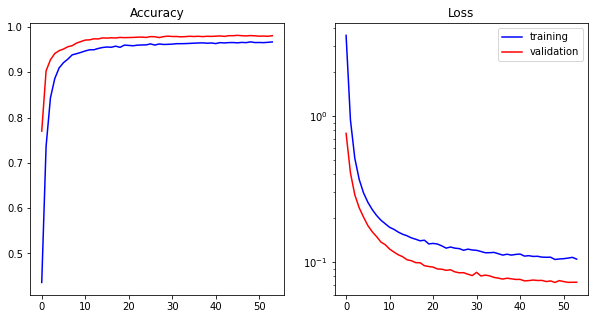

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(epochs, acc, 'b')
ax.plot(epochs, val_acc, 'r')
ax.set_title("Accuracy")

ax = axes[1]
ax.semilogy(epochs, loss, 'b', label = 'training')
ax.semilogy(epochs, val_loss, 'r', label = 'validation')
ax.set_title("Loss")
ax.legend(loc='upper right')

plt.show()

In [39]:
VGG16_feature_extraction_model.save('VGG16_V3a_feature_extraction_model')

INFO:tensorflow:Assets written to: VGG16_V3a_feature_extraction_model/assets


In [22]:
VGG16_feature_extraction_model = keras.models.load_model('VGG16_V3a_feature_extraction_model')

test prediction

In [41]:
img_file = glob.glob('../../Data/datasets/data_test_V1/*.jpg')[0]


img = keras.preprocessing.image.load_img(img_file, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch 
(VGG16_feature_extraction_model.predict(base_model.predict(img_array)), 
np.argmax(VGG16_feature_extraction_model.predict(base_model.predict(img_array)),))

(array([[1.6883546e-06, 7.2748378e-07, 6.8957416e-11, 2.6376783e-16,
         9.9999762e-01, 1.0689955e-17, 2.5430663e-14, 3.1723404e-12,
         3.8164270e-08, 2.0658341e-11, 2.5445472e-17, 3.8189681e-12,
         8.4273647e-12]], dtype=float32),
 4)

### Evaluation<a id='eval_feat_extract'></a>
[top](#top)

In [42]:
def get_VGG16_feature_extraction_model_prediction(filename):
    img = keras.preprocessing.image.load_img(filename, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    preds = base_model.predict(img_array)
    VGG16_feature_extraction_model_prediction = np.argmax(VGG16_feature_extraction_model.predict(preds)[0])
    proba = np.max(VGG16_feature_extraction_model.predict(preds)[0])
    
    return VGG16_feature_extraction_model_prediction, proba

Confusion Matrix using val_dataset

In [43]:
with open('./lst_img_val_V3.pkl', 'rb') as f:
    lst_img_val_V3 = pickle.load(f)

In [44]:
lst_labels = []
lst_preds = []
lst_probs = []
for filename in tqdm(lst_img_val_V3[:]):
    try:
        lst_labels.append(remap_dict[category2label[filename.split('/')[-2]]])
        model_output = get_VGG16_feature_extraction_model_prediction(filename)
        lst_preds.append(model_output[0])
        lst_probs.append(model_output[1])
    except Exception as e:
        print(e)

  0%|          | 0/3944 [00:00<?, ?it/s]

/home/gael/anaconda3/envs/llr_prod2/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (175091056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
print(metrics.classification_report(lst_labels, lst_preds, 
                                    target_names=[x for x in label2category.values()]))

In [ ]:
df_cm = pd.DataFrame(metrics.confusion_matrix(lst_labels, lst_preds),
                     index = [x for x in label2category.values()],
                     columns = [x for x in label2category.values()])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [49]:
df_val = pd.DataFrame({'filename' : lst_img_val_V3,
              'lst_labels' : [remap_dict[x] for x in lst_labels],
              'lst_preds' : lst_preds, 
              'lst_probs' : lst_probs})

len(df_val[df_val['lst_labels'] != df_val['lst_preds']])

## Transfer learning: Fine-tuning<a id='fine_tuning'></a>

[top](#top)

In [26]:
VGG16_feature_extraction_model = keras.models.load_model('VGG16_V3a_feature_extraction_model')

In [27]:
lower_base_model = tf.keras.Model(inputs=base_model.input, 
                             outputs=base_model.get_layer('block4_pool').output)

lower_base_model.trainable = False

In [54]:
# last block of base_model
block5_conv_input = keras.Input(shape=tuple(base_model.get_layer('block4_pool').output.shape.as_list()[1:]), 
                                name='block5_conv1_input')
x = base_model.get_layer('block5_conv1')(block5_conv_input)
x = base_model.get_layer('block5_conv2')(x)
x = base_model.get_layer('block5_conv3')(x)
x = base_model.get_layer('block5_pool')(x)
# feat extraction model
output = VGG16_feature_extraction_model(x)
# fine-tune model
fine_tune_model = keras.Model(block5_conv_input, output, name='fine_tune_model')
fine_tune_model.trainable=True

In [55]:
lower_base_model.get_layer('block4_pool').output.shape.as_list()[1:]

[14, 14, 512]

In [56]:
epochs = 100

fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [57]:
log_dir = "logs/fine-tune/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=0,
                                  mode="auto",
                                  baseline=None,
                                  restore_best_weights=True,
                                 ),
    tensorboard_callback
    ]

In [58]:
history = fine_tune_model.fit(base_model_block4_pool_tr_ds, 
                                epochs=epochs, 
                                validation_data=base_model_block4_pool_val_ds, 
                                callbacks=[callbacks])

Epoch 1/100
1109/1109 [==============================] - 2172s 2s/step - loss: 0.0582 - accuracy: 0.9817 - val_loss: 0.0299 - val_accuracy: 0.9926
Epoch 2/100
1109/1109 [==============================] - 2062s 2s/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0239 - val_accuracy: 0.9942
Epoch 3/100
1109/1109 [==============================] - 2076s 2s/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 4/100
1109/1109 [==============================] - 2079s 2s/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0183 - val_accuracy: 0.9947
Epoch 5/100
1109/1109 [==============================] - 2124s 2s/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 0.0191 - val_accuracy: 0.9952


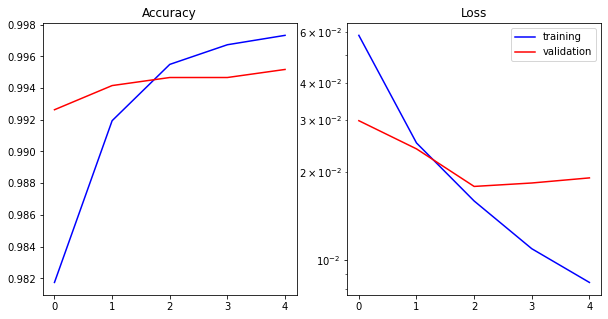

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax = axes[0]
ax.plot(epochs, acc, 'b')
ax.plot(epochs, val_acc, 'r')
ax.set_title("Accuracy")

ax = axes[1]
ax.semilogy(epochs, loss, 'b', label = 'training')
ax.semilogy(epochs, val_loss, 'r', label = 'validation')
ax.set_title("Loss")
ax.legend(loc='upper right')

plt.show()

In [60]:
fine_tune_model.save('VGG16_V3a_fine_tune_model')

INFO:tensorflow:Assets written to: VGG16_V3a_fine_tune_model/assets


In [23]:
fine_tune_model = keras.models.load_model('VGG16_V3a_fine_tune_model')

In [24]:
fine_tune_model.summary()

Model: "fine_tune_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block5_conv1_input (InputLa  [(None, 14, 14, 512)]    0         
 yer)                                                            
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
                                                                 
 model_39441 (Functional)    (None, 13)                6669      
                                                   

### Evaluation<a id='eval_ft'></a>
[top](#top)

In [63]:
def get_fine_tune_model_prediction(filename):
    img = keras.preprocessing.image.load_img(filename, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    preds0 = lower_base_model.predict(img_array)
    fine_tune_model_distrib = fine_tune_model.predict(preds0)[0]

    fine_tune_model_prediction = np.argmax(fine_tune_model_distrib)
    proba = np.max(fine_tune_model_distrib)
    return fine_tune_model_prediction, proba

Matrice de confusion sur images_list_ts

In [64]:
with open('./lst_img_val_V3.pkl', 'rb') as f:
    lst_img_val_V3 = pickle.load(f)

In [65]:
lst_labels_ft = []
lst_preds_ft = []
lst_probs_ft = []
for filename in tqdm(lst_img_val_V3):
    lst_labels_ft.append(file2label[filename])
    model_output = get_fine_tune_model_prediction(filename)
    lst_preds_ft.append(model_output[0])
    lst_probs_ft.append(model_output[1])

  0%|          | 0/3944 [00:00<?, ?it/s]

/home/gael/anaconda3/envs/llr_prod2/lib/python3.8/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (175091056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
print(metrics.classification_report([remap_dict[x] for x in lst_labels_ft], lst_preds_ft, 
                                    target_names=[x for x in label2category.values()]))

In [ ]:
df_cm = pd.DataFrame(metrics.confusion_matrix([remap_dict[x] for x in lst_labels_ft], lst_preds_ft),
                     index = [x for x in label2category.values()],
                     columns = [x for x in label2category.values()])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [69]:
df_val = pd.DataFrame({'filename' : lst_img_val_V3,
              'lst_labels_ft' : [remap_dict[x] for x in lst_labels_ft],
              'lst_preds_ft' : lst_preds_ft, 
              'lst_probs_ft' : lst_probs_ft})

In [ ]:
df_val[df_val['lst_labels_ft'] != df_val['lst_preds_ft']].style

In [76]:
len(df_val[df_val['lst_labels_ft'] != df_val['lst_preds_ft']])/len(df_val)

0.005324543610547667

## Modele for inference<a id='model_infer'></a>
[top](#top)

In [29]:
# Create inference model
inputs = lower_base_model.input
x = lower_base_model(inputs)
outputs = fine_tune_model(x)

classifieur_VGG16_V3a = keras.Model(inputs, outputs)

classifieur_VGG16_V3a.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_4 (Functional)        (None, 14, 14, 512)       7635264   
                                                                 
 fine_tune_model (Functional  (None, 13)               7086093   
 )                                                               
                                                                 
Total params: 14,721,357
Trainable params: 7,086,093
Non-trainable params: 7,635,264
_________________________________________________________________


In [79]:
input_shape = lower_base_model.layers[0].input.shape.as_list()[1:]
input_shape

[224, 224, 3]

In [ ]:
MODEL_DIR = '...'#tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    <model_name>,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

In [32]:
inference_model = keras.models.load_model('.../1')

## Visualization<a id='visu'></a>
[top](#top)

In [68]:
preds = []

for image in tqdm(glob.glob('../../Data/datasets/.../*.jpg')):
    img = keras.preprocessing.image.load_img(image, target_size=(224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    preds.append(label2category[np.argmax(inference_model.predict(img_array))])

  0%|          | 0/279 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(preds).value_counts()

In [6]:
def plot_heatmap(img_array, img_file):
    alpha = 0.8 
    heatmap = tf.reduce_sum(base_model.predict(img_array)[0], 2).numpy()

    # Rescale heatmap to a range 0-255
    M = np.max(heatmap)
    h = (heatmap*255/M)
    heatmap_ = np.uint8(np.ceil(h))

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("cool")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(image_size)
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array[0]

    # Rescale heatmap to a range 0-255
    M = np.max(superimposed_img)
    h = (superimposed_img*255/M)
    superimposed_img_ = np.uint8(np.ceil(h))

    ddp = inference_model.predict(img_array)
    pred = label2category[np.argmax(ddp)]
    prob = np.max(ddp)
    #plt.title(' pred=' +str(pred) + ' P=%.2f' %prob)
    #print(img_file.split('/')[-1])
    
    plt.title('/'.join(img_file.split('/')[-2:]) + '\n pred=' +str(pred) + ' P=%.2f' %prob)
    plt.imshow(superimposed_img_)

    plt.axis("off")


In [7]:
def display_examples(filenames):
    plt.figure(figsize=(15,15))
    alpha = 0.8    
    for i, img_file in enumerate(filenames):
        if i < 2:
            ax = plt.subplot(2, 2, i + 1)
        else:
            ax = plt.subplot(2, 2, i + 1)
        # Load the original image
        img = keras.preprocessing.image.load_img(img_file, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

        plot_heatmap(img_array, img_file)

/home/gael/Service_mails/local_app/data/15761208.pdf_0.jpg
[[9.02275026e-01 1.19527101e-06 3.15699651e-07 8.43276169e-08
  1.27612773e-04 6.13536955e-08 5.36345551e-03 1.49072844e-06
  2.14346190e-04 3.09347747e-08 2.25247029e-04 5.33507628e-05
  1.79366991e-02 6.21346349e-04 2.26068150e-05 3.06103029e-05
  5.44642598e-09 2.91489641e-06 4.11843018e-07 5.28768709e-08
  5.36529132e-09 1.14681960e-07 2.64564815e-08 1.13288046e-09
  6.63744686e-08 1.59847175e-08 1.31745794e-04 7.26932362e-02
  7.35233625e-05 1.54276931e-04 2.46904051e-07 1.28878310e-05
  5.50506993e-05 1.16916866e-07 4.06352171e-07 1.12710484e-06
  1.64895795e-08 1.73704777e-07]]
Autres


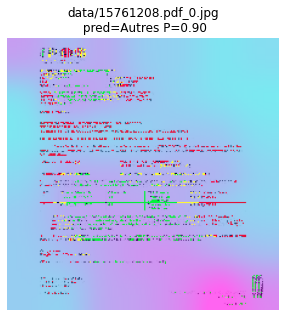

In [16]:
image = '0.jpg'
img = tf.keras.preprocessing.image.load_img(image, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
print(inference_model.predict(img_array))
print(label2category[np.argmax(inference_model.predict(img_array))])
plot_heatmap(img_array, image)